# Assessing linear regression models for predicting house prices

We'll be testing out different methods for predicting housing prices using housing data for or the city of Ames, Iowa, United States from 2006 to 2010. Background to the data collection can be found [here](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627), while the details about the different columns can be found [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

## Setting up functions that will be needed

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [22]:
data = pd.read_csv('AmesHousing.tsv',delimiter='\t')

In [23]:
data.head(5)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

In [29]:
def transform_features(df):
    return df

In [30]:
def select_features(df):
    return df[['Gr Liv Area','SalePrice']]

In [31]:
def train_and_test(df):
    train = df[0:1460]
    test = df[1460:]
    
    # Make sure to only select numerical columns
    train_numeric = train.select_dtypes(include=['integer','float'])
    test_numeric = test.select_dtypes(include=['integer','float'])
    
    # Drop the column that we would like to predict
    train_subset = train_numeric.drop('SalePrice',axis=1)
    test_subset = test_numeric.drop('SalePrice',axis=1)
    
    lr = LinearRegression()
    lr.fit(train_subset, train_numeric['SalePrice'])

    test_predictions = lr.predict(test_subset)
    
    test_rmse = np.sqrt(mean_squared_error(test_numeric['SalePrice'], test_predictions))               
    
    return test_rmse
    

In [32]:
# testing the functions
trans_df = transform_features(data)
filtered = select_features(trans_df)
rmse = train_and_test(filtered)
print(rmse)

57088.25161263909


## Feature engineering

Now we'll prepare the dataset for machine learning by:

- Removing features that are not useful for machine learning
- Removing features that leak data about the final sale
- Removing numeric columns with >= 5% missing values
- Drop any text columns with 1 or more missing values for now
- Filling in the missing values for remaining columns with the mean
- Creating new features by combining other features

In [33]:
# remove columns with >= 5% null values
df_null = data.isnull().sum()
desired_columns = df_null[df_null < round(0.05*len(data),0)]
df_subset = data[desired_columns.index]


In [34]:
# filling in missing values in numerical columns with mean
numeric_columns = df_subset.select_dtypes(include=['integer','float']).columns
df_subset[numeric_columns] = df_subset[numeric_columns].copy().fillna(df_subset[numeric_columns].mean())
# df_subset.head(5)


/dataquest/system/env/python3/lib/python3.4/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [35]:
# removing text columns with >1 missing value
text_cols = df_subset.select_dtypes(include=['object']).columns
text_null = df_subset[text_cols].isnull().sum()
null_text_colls = text_null[text_null > 0]
df_subset = df_subset.drop(null_text_colls.index,axis=1)


In [36]:
# Creating new features by combining other features (year columns)
df_subset['years_since_remod'] = df_subset['Yr Sold'] - df_subset['Year Remod/Add']
df_subset['age'] = df_subset['Yr Sold'] - df_subset['Year Built']
df_subset = df_subset[df_subset['age'] >= 0]
df_subset = df_subset[df_subset['years_since_remod'] >= 0]


In [37]:
# remove columns that leak data about the final sale
# remove columns that aren't useful for machine learning
df_filtered = df_subset.drop(['Mo Sold','Yr Sold','Sale Type','Sale Condition','PID','Order','Year Remod/Add','Year Built'],axis=1)


In [38]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 58 columns):
MS SubClass          2927 non-null int64
MS Zoning            2927 non-null object
Lot Area             2927 non-null int64
Street               2927 non-null object
Lot Shape            2927 non-null object
Land Contour         2927 non-null object
Utilities            2927 non-null object
Lot Config           2927 non-null object
Land Slope           2927 non-null object
Neighborhood         2927 non-null object
Condition 1          2927 non-null object
Condition 2          2927 non-null object
Bldg Type            2927 non-null object
House Style          2927 non-null object
Overall Qual         2927 non-null int64
Overall Cond         2927 non-null int64
Roof Style           2927 non-null object
Roof Matl            2927 non-null object
Exterior 1st         2927 non-null object
Exterior 2nd         2927 non-null object
Mas Vnr Area         2927 non-null float64
Exter Qual    

In [39]:
# Modifying the transform features function
def transform_features(df):
    
    # remove columns with >= 5% null values
    df_null = df.isnull().sum()
    desired_columns = df_null[df_null < round(0.05*len(df),0)]
    df_subset = df[desired_columns.index]
    
    # filling in missing values in numerical columns with mean
    numeric_columns = df_subset.select_dtypes(include=['integer','float']).columns
    df_subset[numeric_columns] = df_subset[numeric_columns].copy().fillna(df_subset[numeric_columns].mean())
    
    # removing text columns with >1 missing value
    text_cols = df_subset.select_dtypes(include=['object']).columns
    text_null = df_subset[text_cols].isnull().sum()
    null_text_colls = text_null[text_null > 0]
    df_subset = df_subset.drop(null_text_colls.index,axis=1)
    
    # Creating new features by combining other features (year columns)
    df_subset['years_since_remod'] = df_subset['Yr Sold'] - df_subset['Year Remod/Add']
    df_subset['age'] = df_subset['Yr Sold'] - df_subset['Year Built']
    df_subset = df_subset[df_subset['age'] >= 0]
    df_subset = df_subset[df_subset['years_since_remod'] >= 0]
    
    # remove columns that leak data about the final sale
    # remove columns that aren't useful for machine learning
    df_filtered = df_subset.drop(['Mo Sold','Yr Sold','Sale Type','Sale Condition','PID','Order','Year Remod/Add','Year Built'],axis=1)

    return df_filtered

In [40]:
# testing the revised function

trans_df = transform_features(data)
filtered = select_features(trans_df)
rmse = train_and_test(filtered)
print(rmse)

/dataquest/system/env/python3/lib/python3.4/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



55275.36731241307


## Feature selection

Now that we have cleaned and transformed a lot of the features in the data set, it's time to move on to feature selection for numerical features. We'll start by seeing which columns correlate most strongly with the SalePrice column.

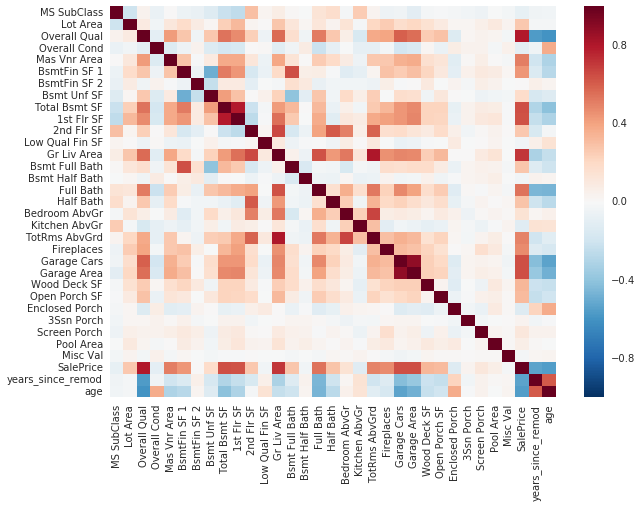

In [41]:
# retaining only numerical columns
filtered_numeric = df_filtered.select_dtypes(include=['integer','float'])

# Plotting a heatmap of correlation coefficients
corrs = filtered_numeric.corr()
plt.figure(figsize = (10,7))
sns.heatmap(corrs)


From the heatmap, we can see that the following columns appear to correlate most strongly with our target SalePrice column:

- Overall Qual
- Total Bsmt SF
- 1st Flr SF
- Gr Liv Area
- Garage Cars
- Garage Area

To avoid dropping too many columns as this stage, let's keep columns that have a correlation of >=0.5.

In [42]:
corrs_target = corrs.loc['SalePrice']
corrs_drop = corrs_target[(corrs_target < 0.5) & (corrs_target > -0.5)]
corrs_drop


MS SubClass       -0.085128
Lot Area           0.267520
Overall Cond      -0.101540
BsmtFin SF 1       0.438928
BsmtFin SF 2       0.006000
Bsmt Unf SF        0.182248
2nd Flr SF         0.269601
Low Qual Fin SF   -0.037629
Bsmt Full Bath     0.276329
Bsmt Half Bath    -0.035874
Half Bath          0.284871
Bedroom AbvGr      0.143916
Kitchen AbvGr     -0.119760
TotRms AbvGrd      0.498574
Fireplaces         0.474831
Wood Deck SF       0.328183
Open Porch SF      0.316262
Enclosed Porch    -0.128685
3Ssn Porch         0.032268
Screen Porch       0.112280
Pool Area          0.068438
Misc Val          -0.019273
Name: SalePrice, dtype: float64

In [43]:
df_filtered = df_filtered.drop(corrs_drop.index, axis=1)


Total Bsmt SF & 1st Flr SF, and Garage Cars & Garage Area correlate strongly with each other. We'll only use Garage Area and Bsmt Flr SF. The former because it is a continuous variable that has more information than Garage Cars, and the latter because the correlation is slighly stronger.

In [44]:
df_filtered = df_filtered.drop(['Garage Cars','1st Flr SF'], axis=1)
df_filtered.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 34 columns):
MS Zoning            2927 non-null object
Street               2927 non-null object
Lot Shape            2927 non-null object
Land Contour         2927 non-null object
Utilities            2927 non-null object
Lot Config           2927 non-null object
Land Slope           2927 non-null object
Neighborhood         2927 non-null object
Condition 1          2927 non-null object
Condition 2          2927 non-null object
Bldg Type            2927 non-null object
House Style          2927 non-null object
Overall Qual         2927 non-null int64
Roof Style           2927 non-null object
Roof Matl            2927 non-null object
Exterior 1st         2927 non-null object
Exterior 2nd         2927 non-null object
Mas Vnr Area         2927 non-null float64
Exter Qual           2927 non-null object
Exter Cond           2927 non-null object
Foundation           2927 non-null object
Total Bsmt 

Now we'll look at columns containing nominal data and ordinal data. For these columns, what we'll consider is:

- If a categorical column has hundreds of unique values (or categories), should we keep it? 
- Which columns have a few unique values but more than 95% of the values belong to a specific category? These have low variance and would not contribute much to the target values
- Which columns are currently numerical but need to be encoded as categorical instead (because the numbers don't have any semantic meaning)?

Then we'll convert the categorical data to dummy values.

In [45]:
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]


In [46]:
## How many unique values in each categorical column?
transform_cat_cols = []
for col in nominal_features:
        if col in df_filtered.columns:
            transform_cat_cols.append(col)
uniqueness_counts = df_filtered[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()

# Aribtrary cutoff of 10 unique values
drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
df_filtered = df_filtered.drop(drop_nonuniq_cols, axis=1)
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 31 columns):
MS Zoning            2927 non-null object
Street               2927 non-null object
Lot Shape            2927 non-null object
Land Contour         2927 non-null object
Utilities            2927 non-null object
Lot Config           2927 non-null object
Land Slope           2927 non-null object
Condition 1          2927 non-null object
Condition 2          2927 non-null object
Bldg Type            2927 non-null object
House Style          2927 non-null object
Overall Qual         2927 non-null int64
Roof Style           2927 non-null object
Roof Matl            2927 non-null object
Mas Vnr Area         2927 non-null float64
Exter Qual           2927 non-null object
Exter Cond           2927 non-null object
Foundation           2927 non-null object
Total Bsmt SF        2927 non-null float64
Heating              2927 non-null object
Heating QC           2927 non-null object
Central Ai

In [49]:
# finding columns where >95% of the values are a single value
variance = {}

for c in df_filtered.columns:
    if c in nominal_features:
        counts = df_filtered[c].value_counts()
        variance[c] = counts[0]

print(variance)
low_variance = []

for key, value in variance.items():
    threshold = round(0.95*len(df_filtered))
    if value >= threshold:
        low_variance.append(key)

print(low_variance)

{'Roof Matl': 2884, 'Heating': 2882, 'Central Air': 2731, 'Condition 1': 2520, 'Land Contour': 2632, 'Lot Config': 2138, 'Condition 2': 2898, 'Foundation': 1307, 'MS Zoning': 2270, 'Street': 2915, 'Roof Style': 2320, 'Bldg Type': 2422, 'House Style': 1480}
['Roof Matl', 'Heating', 'Condition 2', 'Street']


From the value counts, we can see that a few categorical columns have >95% of the values in specific category, so we shall drop them.

In [50]:
df_filtered = df_filtered.drop(low_variance,axis=1)

In [51]:
# Select just the remaining text columns and convert to categorical
text_cols = df_filtered.select_dtypes(include=['object'])
for col in text_cols:
    df_filtered[col] = df_filtered[col].astype('category')
    
# Create dummy columns and add back to the dataframe
df_filtered = pd.concat([
    df_filtered, 
    pd.get_dummies(df_filtered.select_dtypes(include=['category']))
], axis=1).drop(text_cols,axis=1)

df_filtered.head(5)

,Overall Qual,Mas Vnr Area,Total Bsmt SF,Gr Liv Area,Full Bath,Garage Area,SalePrice,years_since_remod,age,MS Zoning_A (agr),...,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Paved Drive_N,Paved Drive_P,Paved Drive_Y
0,6,112.0,1080.0,1656,1,528.0,215000,50,50,0,...,0,0,0,0,0,0,1,0,1,0
1,5,0.0,882.0,896,1,730.0,105000,49,49,0,...,0,0,0,0,0,0,1,0,0,1
2,6,108.0,1329.0,1329,1,312.0,172000,52,52,0,...,0,0,0,0,0,0,1,0,0,1
3,7,0.0,2110.0,2110,2,522.0,244000,42,42,0,...,0,0,0,0,0,0,1,0,0,1
4,5,0.0,928.0,1629,2,482.0,189900,12,13,0,...,0,0,0,0,0,0,1,0,0,1


Now that we've worked through the steps for selecting features, we'll updated the select_features functions.

In [52]:
def select_features(df, coeff_threshold=0.5, uniq_threshold=10):
    
    # retaining only numerical columns
    filtered_numeric = df.select_dtypes(include=['integer','float'])
    
    # Calculating correlations with SalePrice column
    # Retain those within desired threshold
    corrs = filtered_numeric.corr()
    corrs_target = corrs.loc['SalePrice']
    corrs_drop = corrs_target[(corrs_target < coeff_threshold) & (corrs_target > -coeff_threshold)]
    df = df.drop(corrs_drop.index, axis=1)
    
    # Only keep nominal columns with 10 or less unique values
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > uniq_threshold].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    # finding columns where >95% of the values are a single value
    variance = {}
    
    for c in df.columns:
        if c in nominal_features:
            counts = df[c].value_counts()
            variance[c] = counts[0]

    low_variance = []

    for key, value in variance.items():
        threshold = round(0.95*len(df_filtered))
        if value >= threshold:
            low_variance.append(key)
    
    # Drop these columns
    df = df.drop(low_variance,axis=1)
    
    # Select just the remaining text columns and convert to categorical
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    
    # Create dummy columns and add back to the dataframe
    df = pd.concat([df, 
                    pd.get_dummies(df.select_dtypes(include=['category']))], 
                            axis=1).drop(text_cols,axis=1)
    
    return df

## Training and testing the model

Now we'll develop the function for training and testing the model based on the features we have engineered and selected. As we have multiple features, we'll use simple validation.

In [57]:
def train_and_test(df, k=0):
    # Make sure to only select numerical columns
    numeric = df.select_dtypes(include=['integer','float'])
    features = numeric.drop('SalePrice',axis=1).columns
    lr = LinearRegression()
    
    # holdout validation
    if k == 0:
        train = df[0:1460]
        test = df[1460:]
        
        lr.fit(train[features], train['SalePrice'])
        test_predictions = lr.predict(test[features])
        test_rmse = np.sqrt(mean_squared_error(test['SalePrice'], test_predictions))               
    
        return test_rmse

    # simple cross validation
    if k == 1:
        # Shuffle the order of rows
        rand = np.random.permutation(df.index)
        df = df.reindex(rand)
        
        # split into 2 folds
        fold_one = df[0:1460]
        fold_two = df[1460:]
        
        # train and test on each fold
        lr.fit(fold_one[features], fold_one['SalePrice'])
        foldtwo_predictions = lr.predict(fold_two[features])
        two_rmse = np.sqrt(mean_squared_error(fold_two['SalePrice'], foldtwo_predictions))
        
        lr.fit(fold_two[features], fold_two['SalePrice'])
        foldone_predictions = lr.predict(fold_one[features])
        one_rmse = np.sqrt(mean_squared_error(fold_one['SalePrice'], foldone_predictions))               
        
        avg_rmse = np.mean([two_rmse, one_rmse])
        return avg_rmse
    
    else:
        kf = KFold(k, shuffle=True, random_state=1)
        
        mses = cross_val_score(lr, df[features], df['SalePrice'], scoring="neg_mean_squared_error", cv=kf)
        
        rmses = np.sqrt(np.absolute(mses))
        avg_rmse_kfold = np.mean(rmses)
        return (avg_rmse_kfold, rmses)
    

In [58]:
# testing the revised functions

trans_df = transform_features(data)
filtered = select_features(trans_df)
rmse = train_and_test(filtered,k=0)
print(rmse)

/dataquest/system/env/python3/lib/python3.4/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



33338.303397020325


In [59]:
# testing the revised functions

trans_df = transform_features(data)
filtered = select_features(trans_df)
rmse = train_and_test(filtered,k=1)
print(rmse)

/dataquest/system/env/python3/lib/python3.4/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



31311.81181413907


In [60]:
# testing the revised functions

trans_df = transform_features(data)
filtered = select_features(trans_df)
rmse = train_and_test(filtered,k=4)
print(rmse)

/dataquest/system/env/python3/lib/python3.4/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



(30159.191616211654, array([36334.47847988, 26635.04235577, 27575.6083289 , 30091.6373003 ]))


Possible next steps:

- Continue iteration on feature engineering:

    - Reserach some other approaches to feature engineering online around housing data.
    - Visit the Kaggle kernels page for this dataset to see approaches others took.

- Improve your feature selection:
    - Research ways of doing feature selection better with categorical columns (something we didn't cover in this particular course).

## Conclusion

We selected features and tested linear regression models on a set of housing data, and what we found was that using 4-fold cross validation produced better results (smaller mean squared errors) than holdout validation or simple cross validation.